# Compare Multiclass Classification Models

Multiclass classification can be a combination of multiple binary classifiers. There are two ways to approach this problem:

- **One vs Rest (OVR)**, in which a classifier is created for each possible class value, with a positive outcome for cases where the prediction is *this* class, and negative predictions for cases where the prediction is any other class. A classification problem with three possible penguin classes (*square*, *circle*, *triangle*, *hexagon*) would require four classifiers that predict:
    - *Adelie* or not
    - *Gentoo* or not
    - *Chinstrap* or not
    
- **One vs One (OVO)**, in which a classifier for each possible pair of classes is created. The classification problem with three penguin classes would require the following binary classifiers:
    - *Adelie* or *Gentoo*
    - *Adelie* or *Chinstrap*
    - *Chinstrap* or *Gentoo*

In both approaches, the overall model that combines the classifiers generates a vector of predictions, in which the probabilities generated from the individual binary classifiers are used to determine which class to predict.

In [1]:
import urllib.request
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/penguins.csv"

# Download the file
urllib.request.urlretrieve(url, "penguins.csv")

# Assuming the file is downloaded correctly
penguins = pd.read_csv('penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [31]:
# Group column names
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
labels = ['Species']

# Additional information about penguin classes
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(penguins.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[', row[0], row[1], row[2], row[3], int(row[4]),']', penguin_classes[int(row[4])])


['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 36.0 17.9 190.0 3450.0 0 ] Adelie
[ 35.0 17.9 192.0 3725.0 0 ] Adelie
[ 45.5 13.7 214.0 4650.0 1 ] Gentoo
[ 54.3 15.7 231.0 5650.0 1 ] Gentoo
[ 47.5 14.0 212.0 4875.0 1 ] Gentoo
[ 47.5 16.8 199.0 3900.0 2 ] Chinstrap
[ 50.0 16.3 230.0 5700.0 1 ] Gentoo
[ 49.7 18.6 195.0 3600.0 2 ] Chinstrap
[ 32.1 15.5 188.0 3050.0 0 ] Adelie
[ 40.1 18.9 188.0 4300.0 0 ] Adelie


In [24]:
# Count the number of null values for each column
print(penguins.isnull().sum())

# Show rows containing nulls
print("\n\nRows containing nulls")
penguins[penguins.isnull().any(axis=1)]

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64


Rows containing nulls


,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species


In [25]:
# There are two rows that contain no feature values at all (*NaN* means "not a number"), so these won't be useful in training a model. Let's discard them from the dataset.
# Drop rows containing NaN values
penguins=penguins.dropna()

#Confirm there are now no nulls
penguins.isnull().sum()

CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64

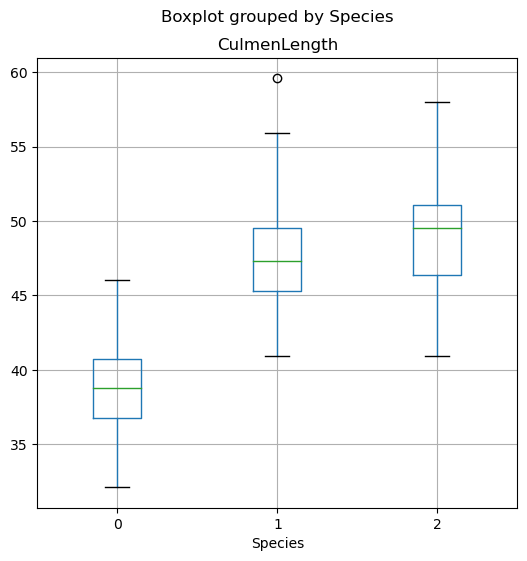

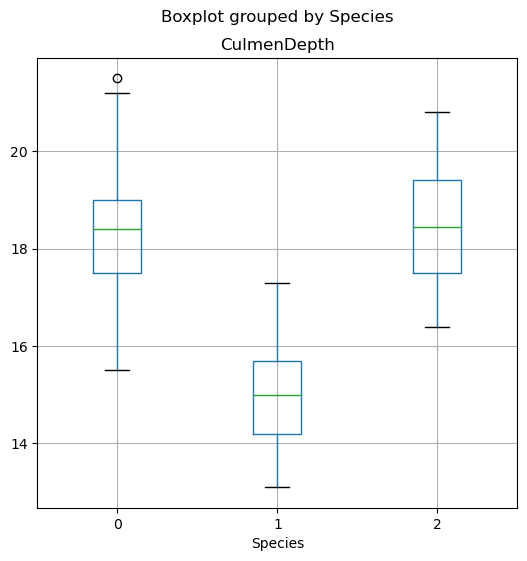

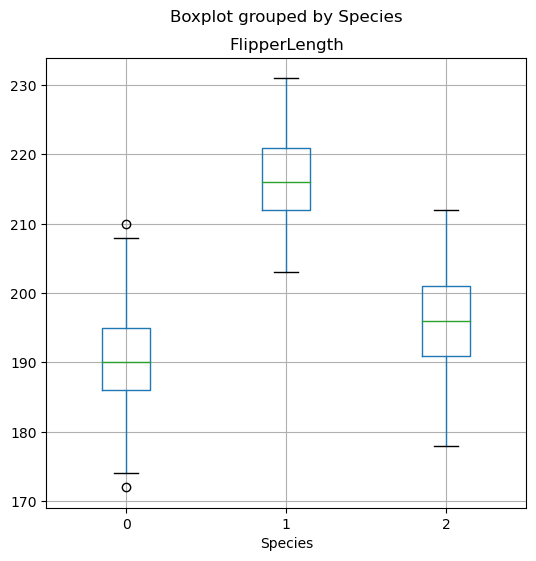

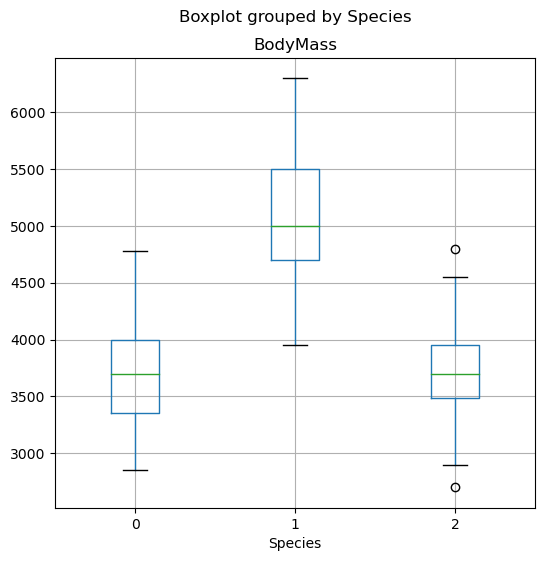

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'
for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()

In [32]:
# Create train and test set
from sklearn.model_selection import train_test_split

# Create input and output features
X, y = penguins[features].values, penguins[labels].values

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Flatten the output data
y_train = y_train.flatten()
y_test = y_test.flatten()

# Print stats
print(f"Number of training records: {len(X_train)}\nNumber of test records: {len(X_test)}")

Number of training records: 239
Number of test records: 103


## Helper functions

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, classification_report

def create_pipeline(model):
    # Define preprocessing for numeric columns (normalize them so they're on the same scale)
    numeric_features = [0,1,2,3]
    numeric_transformer = Pipeline(steps=[
                                        ('scaler', StandardScaler())])
    
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)])
    
    # Create preprocessing and training pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', model)])
    
    return pipe

# Train the model
def train_model(pipeline):
    # Train the model pipeline
    model = pipeline.fit(X_train, y_train)

    return model

# Evaluate model
def evaluate_model(model):
    # Make prediction
    predictions = model.predict(X_test)

    # Print model name
    print(f"Model: {model['regressor']}\n")

    # Run a classification Report
    print(f"\nClassification Report: \n{classification_report(y_test, predictions)}\n")

    msg = """Defintions:
    *Precision*: Of the predictions the model made for this class, what proportion were correct?
    *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
    *F1-Score*: An average metric that takes both precision and recall into account.
    *Support*: How many instances of this class are there in the test dataset?
    """
    print(msg + '\n')    

    print(f"Overall Precision: {precision_score(y_test, predictions, average='macro')*100:.2f}%")
    print(f"Overall Recall: {recall_score(y_test, predictions, average='macro')*100:.2f}%")
    print(f"Accuracy: {accuracy_score(y_test, predictions)*100:.2f}%\n")
    
    # Get evaluation metrics
    cm = confusion_matrix(y_test, predictions)
    print ('Confusion Matrix:\n',cm, '\n')

    # For multi class classification models, it might be easier to visualise with a heatmap
    print("Confusion Matrix as a heatmap")
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(penguin_classes))
    plt.xticks(tick_marks, penguin_classes, rotation=45)
    plt.yticks(tick_marks, penguin_classes)
    plt.xlabel("Predicted Species")
    plt.ylabel("Actual Species")
    plt.show()


# Draw the ROC curve for the model classes using 'One vs Rest'
def draw_roc_curve(model):
    # Get class probability scores
    penguin_prob = model.predict_proba(X_test)

    # Get ROC metrics for each class
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(len(penguin_classes)):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, penguin_prob[:,i], pos_label=i)
        
    # Plot the ROC chart
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=penguin_classes[0] + ' vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=penguin_classes[1] + ' vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=penguin_classes[2] + ' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

    # Print Avg AUC for the model
    auc = roc_auc_score(y_test,penguin_prob, multi_class='ovr')
    print(f"Average AUC: {auc:.4f}")
    

## Model 1: Logistic Regression

In this example, we'll use *Logistic Regression*, which is a well-established algorithm for classification. In addition to the training features and labels, we'll need to set a *regularization* parameter. This is used to counteract any bias in the sample, and help the model generalize well by avoiding *overfitting* the model to the training data.

Model: LogisticRegression(C=10.0, max_iter=10000)


Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      1.00      1.00        34
           2       0.95      0.95      0.95        19

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103


Defintions:
    *Precision*: Of the predictions the model made for this class, what proportion were correct?
    *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
    *F1-Score*: An average metric that takes both precision and recall into account.
    *Support*: How many instances of this class are there in the test dataset?
    

Overall Precision: 97.58%
Overall Recall: 97.58%
Accuracy: 98.06%

Confusion Matrix:
 [[49  0  1]
 [ 0 34  0]
 [ 1  0 18]] 

Confusion Matrix as a heatma

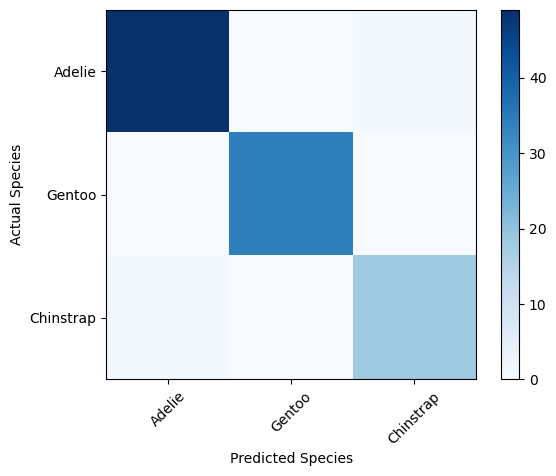

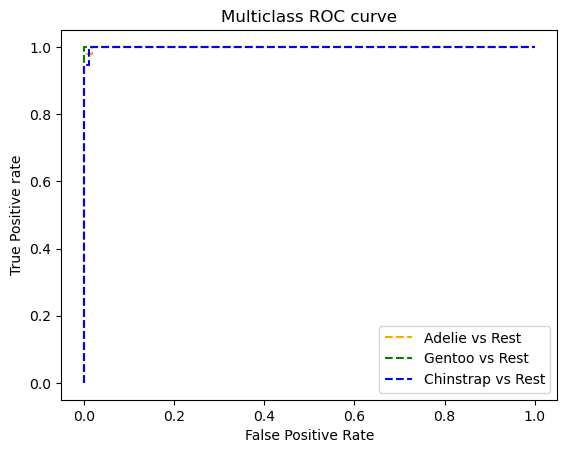

Average AUC: 0.9997


In [62]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# Define model
model_def = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000)

# Create pipeline
pipe = create_pipeline(model_def)

# Train model
model_lr = train_model(pipeline=pipe)

# Evaluate model
evaluate_model(model_lr)

# ROC Curve
draw_roc_curve(model_lr)

## Model 2 : Support Vector Classifier

Model: SVC(probability=True)


Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      1.00      1.00        34
           2       0.95      0.95      0.95        19

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103


Defintions:
    *Precision*: Of the predictions the model made for this class, what proportion were correct?
    *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
    *F1-Score*: An average metric that takes both precision and recall into account.
    *Support*: How many instances of this class are there in the test dataset?
    

Overall Precision: 97.58%
Overall Recall: 97.58%
Accuracy: 98.06%

Confusion Matrix:
 [[49  0  1]
 [ 0 34  0]
 [ 1  0 18]] 

Confusion Matrix as a heatmap


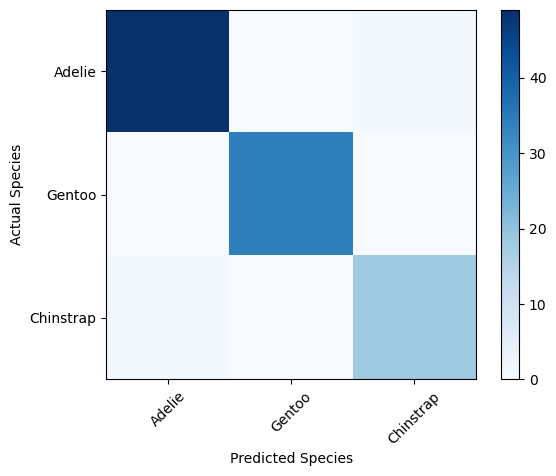

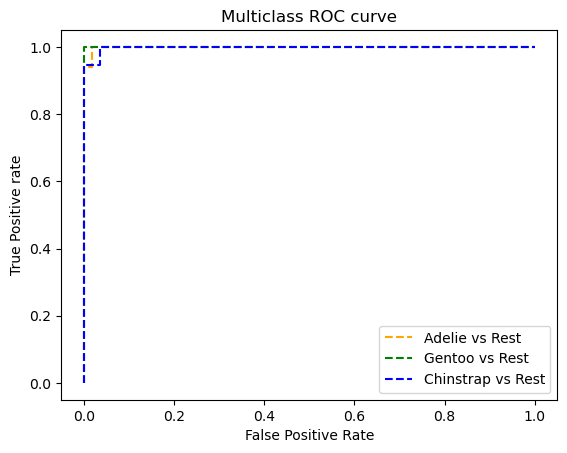

Average AUC: 0.9990


In [63]:
# Train the SVC model
from sklearn.svm import SVC

# Define model
model_def = SVC(probability=True)

# Create pipeline
pipe = create_pipeline(model_def)

# Train model
model_svc = train_model(pipeline=pipe)

# Evaluate model
evaluate_model(model_svc)

# ROC Curve
draw_roc_curve(model_svc)

In [ ]:
# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model_rf.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.9091702, 1.488172308, 22.0]
Predicted class is 1


In [75]:
# The model accepts an array of feature arrays (so you can predict the classes of multiple penguin observations in a single call)
x_new = np.array([[49.5,18.4,195, 3600],
         [38.2,20.1,190,3900]])

# The model returns an array of predictions - one for each set of features submitted
predictions = model_svc.predict(x_new)

# Get the predicted classes.
for input, pred in list(zip(x_new, predictions)):
    print("Input features:")
    for i in range(0,len(input)):
        print(f"  {features[i]} : {input[i]}")

    print(f"\n* Predicted Class: {penguin_classes[pred]}\n ===========================")


Input features:
  CulmenLength : 49.5
  CulmenDepth : 18.4
  FlipperLength : 195.0
  BodyMass : 3600.0

* Predicted Class: Chinstrap
Input features:
  CulmenLength : 38.2
  CulmenDepth : 20.1
  FlipperLength : 190.0
  BodyMass : 3900.0

* Predicted Class: Adelie
